In [1]:
import sys, os
sys.path.append('/home/A00512318/TCN')
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from TCN.mnist_pixel.utils import data_generator
from TCN.mnist_pixel.model import TCN
import numpy as np
import argparse

# set default values for model
batch_size = 100
cuda = True
dropout = 0.10
clip = -1
epochs = 20
kernel_size = 7
levels = 12
log_interval = 100
lr = 2e-3
optimm = 'Adam'
nhid = 25
seed = 1111
permutee = False
root = '../data/fashion_mnist'
save_filename = './checkpoints/fashionmnist/fashionmnist_filters.pt'
input_channels = 1
n_classes = 10
seq_length = int(784 / input_channels)
steps = 0

In [2]:
from torchvision import datasets, transforms

def data_generator(root, batch_size):
    train_set = datasets.FashionMNIST(root=root, train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))
    test_set = datasets.FashionMNIST(root=root, train=False, download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))
                              ]))

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
    return train_loader, test_loader

train_loader, test_loader = data_generator(root, batch_size)

classes = ('T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
# print(classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ankle boot T-shirt/Top T-shirt/Top Dress T-shirt/Top Pullover Sneaker Pullover Sandal Sandal T-shirt/Top Ankle boot Sandal Sandal Sneaker Ankle boot Trouser T-shirt/Top Shirt  Coat Dress Trouser  Coat   Bag  Coat Dress T-shirt/Top Pullover  Coat  Coat Sandal Dress Shirt Shirt T-shirt/Top   Bag Sandal Pullover Trouser Shirt Shirt Sneaker Ankle boot Sandal Ankle boot Pullover Sneaker Dress T-shirt/Top Dress Dress Dress Sneaker Pullover Pullover Shirt Shirt   Bag Dress Dress Sandal T-shirt/Top Sandal Sandal T-shirt/Top Pullover T-shirt/Top T-shirt/Top  Coat Trouser Dress Trouser Shirt Dress Trouser  Coat  Coat Shirt Trouser Ankle boot Trouser Dress Sandal Sneaker Ankle boot Sneaker Trouser Sneaker Ankle boot Ankle boot Ankle boot Dress Pullover Ankle boot Dress Shirt  Coat Trouser Trouser   Bag


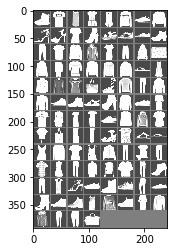

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

unique_images = {}
seen = set()
for i in range(batch_size):
    if labels[i] not in seen:
        seen.add(labels[i].item())
#         print(seen)
        unique_images[labels[i].item()] = images[i]

# print([label[0] for label in unique_images])
# print(seen)
# print(labels)
# print()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [36]:
def plot_sample_predictions(classes, images):
    """
    This function displays images randomly and tries to predict the correct class
    stolen from here: https://github.com/cmasch/zalando-fashion-mnist/blob/master/Simple_Convolutional_Neural_Network_Fashion-MNIST.ipynb
    """

    class_ = 0
    images_per_row = 5
    rows = len(classes) // images_per_row
#     print(rows)
    ii = 0;
    for i in range(rows):
        fig, axis = plt.subplots(1, images_per_row)
     
        for i, axis in enumerate(axis):
#             print(axis, i)
            fig.set_size_inches(15, 25)
            axis.text(0,36,classes[ii])
            axis.imshow(images[ii][0] / 2 + 0.5, cmap='gray')
            axis.axis('off')
            class_ +=1
            ii += 1
    fig.savefig('./classes.png')
    plt.show()
    

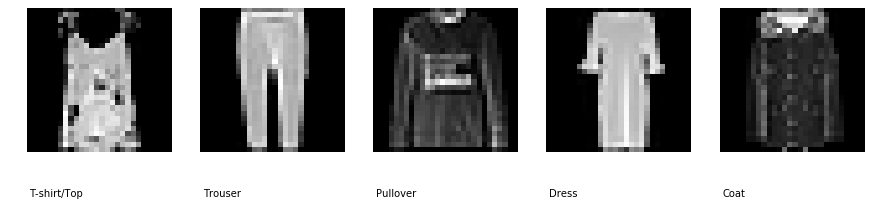

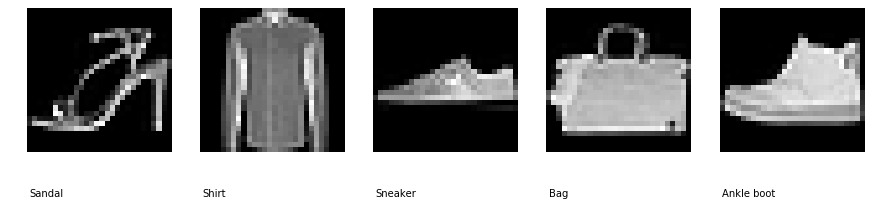

In [37]:
# fig = plt.figure()
# for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.tight_layout()
#   plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#   plt.title("Ground Truth: {}".format(example_targets[i]))
#   plt.xticks([])
#   plt.yticks([])
# fig

dataiter = iter(train_loader)
images, labels = dataiter.next()
plot_sample_predictions(classes, unique_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1,
        2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5, 1, 1, 2, 3, 9, 8, 7, 0,
        2, 6, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2, 0, 6, 5, 3, 6, 7, 1, 8,
        0, 1, 4, 2])
Ankle boot Pullover Trouser Trouser Shirt Trouser  Coat Shirt Sandal Sneaker  Coat Sandal Sneaker Dress  Coat Trouser Pullover  Coat   Bag T-shirt/Top Pullover Sandal Sneaker Ankle boot Trouser  Coat Shirt T-shirt/Top Ankle boot Dress   Bag   Bag Dress Dress   Bag T-shirt/Top Sneaker Sandal Sneaker Ankle boot Shirt Trouser Dress Sneaker Shirt Sneaker Pullover Trouser Pullover Pullover  Coat  Coat Sandal   Bag Pullover Pullover   Bag  Coat   Bag T-shirt/Top Sneaker Sneaker   Bag Sandal Trouser Trouser Pullover Dress Ankle boot   Bag Sneaker T-shirt/Top Pullover Shirt Pullover Dress Trouser Pullover   Bag  Coat Trouser   Bag Sandal Ankle boot Sandal T-s

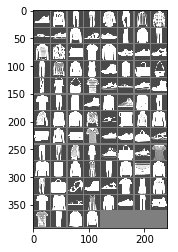

In [29]:
# sanity check for validation data
dataiter = iter(test_loader)
images, labels = dataiter.next()
print(labels)
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

permute = torch.Tensor(np.random.permutation(784).astype(np.float64)).long()
channel_sizes = [nhid] * levels
model = TCN(input_channels, n_classes, channel_sizes, kernel_size=kernel_size, dropout=dropout)

model = nn.DataParallel(model)
model.to(device)

# permute = permute.cuda()
permute = permute.to(device)
optimizer = getattr(optim, optimm)(model.parameters(), lr=lr)

In [19]:
def trainTCN(ep):
    global steps
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda: 
            data, target = data.to(device), target.to(device)
        data = data.view(-1, input_channels, seq_length)
        if permutee:
            data = data[:, :, permute]
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        if clip > 0:
            torch.nn.utils.clip_grad_norm(model.parameters(), clip)
        optimizer.step()
        train_loss += loss.item()
#         loss_.append(train_loss)
        steps += seq_length
        if batch_idx > 0 and batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tSteps: {}'.format(
                ep, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), train_loss/log_interval, steps))
            train_loss = 0

In [20]:
def testTCN():
    test_loss = 0
    correct = 0
    correct_class = list(0. for i in range(10))
    correct_total = list(0. for i in range(10))
    tot = 0
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.to(device), target.to(device)
            data = data.view(-1, input_channels, seq_length)
            if permutee:
                data = data[:, :, permute]
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            _, pred = torch.max(output, 1)
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
#             print(len(target.data.view_as(pred)))
            c = (pred == target).squeeze()
            tot += 1
#             if tot != 313:
#             for i in range(len(test_loader.dataset) // batch_size):
# #                     print(pred[i], target.data.view_as(pred)[i])
#                 print(i)
#                 label = pred[i]
#                 if (pred[i] == target.data.view_as(pred)[i]):
#                     correct_class[label] += c[i].item()
#                 correct_total[label] += 1
                    
                
#     print(tot)
#     for i in range(10):
#         print('Accuracy of %5s : %2d %%' % (
#             classes[i], 100 * correct_class[i] / correct_total[i]))

    test_loss /= len(test_loader.dataset)
#     print(correct.item())
    accuracy_.append(correct.item() / 10000.)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

In [21]:
def save(model):
    torch.save(model, save_filename)
    print('Saved as %s' % save_filename)

In [ ]:
accuracy_ = []
loss_ = []
# def runModel():
for epoch in range(1, epochs+1):
    trainTCN(epoch)
    testTCN()
    if epoch % 5 == 0: 
        print('Saving model.....')
        save(model) 
    if epoch % 10 == 0:
        lr /= 10
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
            

Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.160145	Steps: 79184
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.659271	Steps: 157584
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.564013	Steps: 235984
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.519359	Steps: 314384
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.480578	Steps: 392784


/home/A00512318/anaconda3/envs/tcn/lib/python3.7/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.4652, Accuracy: 8289/10000 (82%)

Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.448304	Steps: 549584
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.444629	Steps: 627984
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.422516	Steps: 706384
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.409574	Steps: 784784
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.400198	Steps: 863184

Test set: Average loss: 0.4145, Accuracy: 8491/10000 (84%)

Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.389837	Steps: 1019984
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.387617	Steps: 1098384
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.377941	Steps: 1176784
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.375296	Steps: 1255184
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.358803	Steps: 1333584

Test set: Average loss: 0.3889, Accuracy: 8556/10000 (85%)

Train Epoch: 4 [10000/60000 (17%)]	Loss: 0.361657	Steps: 1490384
Train Epoch: 4 [20000/60000 (33%)]	Loss: 0.365421	Steps: 1568784
Train Epoch: 4 [30000/60000 (50%)]	Loss: 0

In [ ]:
loaded_model = None
with open(save_filename, 'rb') as f:
        loaded_model = torch.load(f)
#         print(model)
        
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

In [ ]:
loaded_model.to(device)
# kernel = loaded_model.module.tcn.network[0].net[0].weight.data.clone()
# kernel.shape
# kernel
# loaded_model.module.tcn.network
loaded_model.module.tcn.network[0].net

In [ ]:
fig = plt.figure()
plt.figure(figsize=(10,10))
for idx, filt  in enumerate(kernel):
#     print(filt[0, :])
#     print(filt[0, :])
#     plt.subplot(4,7, idx + 1)
    plt.imshow(filt, cmap="gray")
    plt.axis('off')
    
    
fig.show()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.arange(1, 21)
# s = 1 + np.sin(2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(t, accuracy_)

ax.set(xlabel='Epoch', ylabel='Accuracy',
       title='TCN')
ax.grid()

fig.savefig("test.png")
plt.show()

In [ ]:
mode

In [ ]:
model.to